In [569]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn import datasets
from sklearn import model_selection
from sklearn import linear_model
from sklearn import ensemble
from sklearn import neighbors
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

from xgboost import XGBClassifier, plot_importance

In [570]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


In [571]:
# 인자로 사이킷런의 Estimator객체와, 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행.
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None, eval_set=None):
    model.fit(ftr_train, tgt_train, eval_set=eval_set)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)


In [572]:
# 데이터 로딩 후 데이터 확인
data_df = pd.read_csv('../data/titanic/train.csv')
test_df = pd.read_csv('../data/titanic/test.csv')
data_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [573]:
data_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [574]:
# 예측 결과에 영향을 끼치지 않을 것 같은 PassengerId Ticket Cabin은 제외하였습니다.
data_df = data_df.drop(['PassengerId','Ticket','Cabin'],axis = 1)
# 테스트 데이터
test_df= test_df.drop(['PassengerId','Ticket','Cabin'],axis = 1)

In [575]:
X_features = data_df.copy() 
y_labels = data_df[['Survived']] 
del X_features['Survived']

In [576]:
X_features

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.0000,S
887,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.0000,S
888,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,23.4500,S
889,1,"Behr, Mr. Karl Howell",male,26.0,0,0,30.0000,C


생존률 확인

1. 성별

In [577]:
data_df.groupby(['Sex'])['Survived'].mean()*100
# groupby -> 선택한 column의 요소별로 행을 나눔

Sex
female    74.203822
male      18.890815
Name: Survived, dtype: float64

<Axes: xlabel='Sex'>

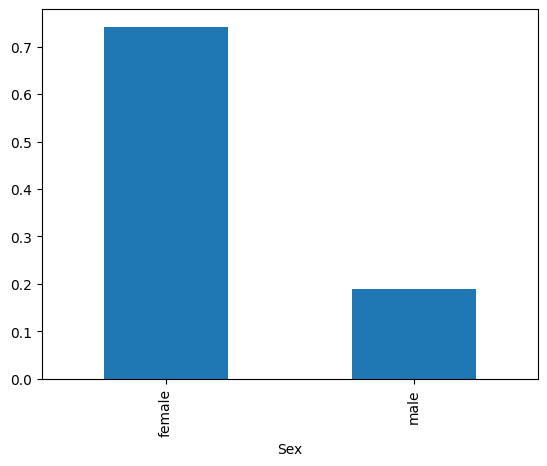

In [578]:
data_df.groupby(['Sex'])['Survived'].mean().plot(kind='bar')

남성보다 여성이 높은것을 확인

2, 승선항

In [579]:
data_df.groupby(['Embarked'])['Survived'].mean()*100

Embarked
C    55.357143
Q    38.961039
S    33.695652
Name: Survived, dtype: float64

<Axes: xlabel='Embarked'>

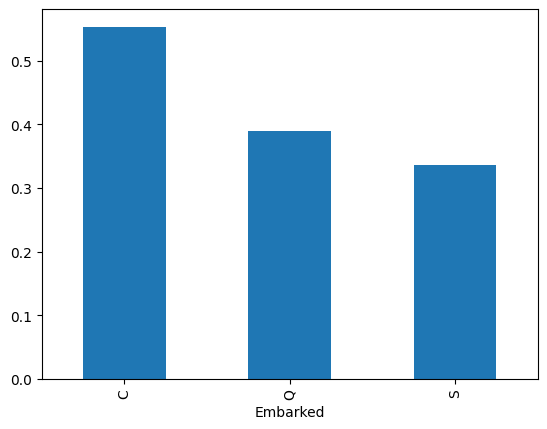

In [580]:
data_df.groupby(['Embarked'])['Survived'].mean().plot(kind='bar')

승성항도 차이가 난다는것을 확인

3. 가족

In [581]:
data_df.groupby(['Parch'])['Survived'].mean()*100

Parch
0    34.365782
1    55.084746
2    50.000000
3    60.000000
4     0.000000
5    20.000000
6     0.000000
Name: Survived, dtype: float64

<Axes: xlabel='Parch'>

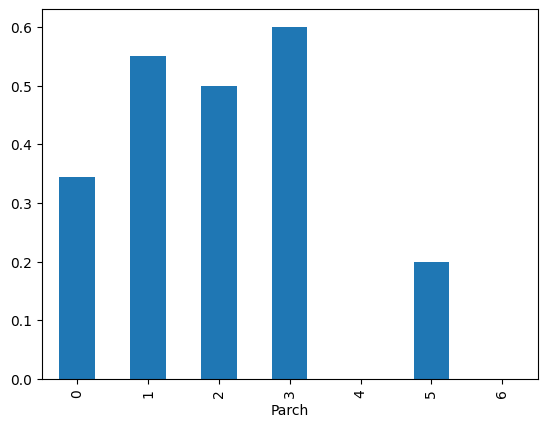

In [582]:
data_df.groupby(['Parch'])['Survived'].mean().plot(kind='bar')

이상함

4. 배우자/ 형제,자매

In [583]:
data_df.groupby(['SibSp'])['Survived'].mean()*100

SibSp
0    34.539474
1    53.588517
2    46.428571
3    25.000000
4    16.666667
5     0.000000
8     0.000000
Name: Survived, dtype: float64

<Axes: xlabel='SibSp'>

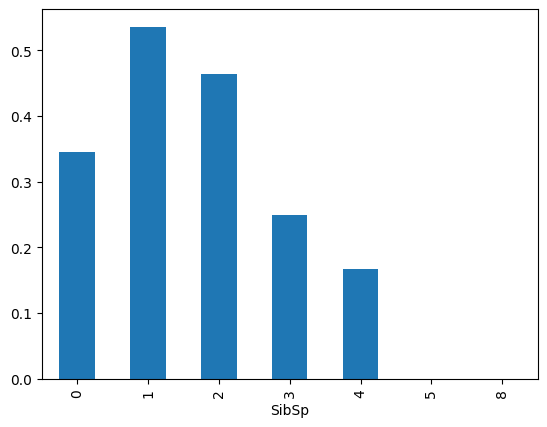

In [584]:
data_df.groupby(['SibSp'])['Survived'].mean().plot(kind='bar')

음...

5.객실

In [585]:
data_df.groupby(['Pclass'])['Survived'].mean()*100

Pclass
1    62.962963
2    47.282609
3    24.236253
Name: Survived, dtype: float64

<Axes: xlabel='Pclass'>

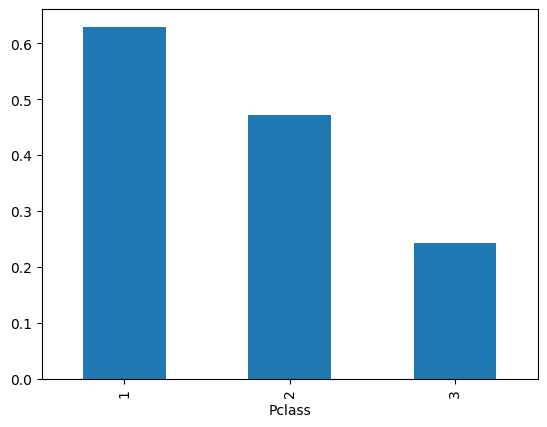

In [586]:
data_df.groupby(['Pclass'])['Survived'].mean().plot(kind='bar')

객실 위치에따라 다름

6.나이

In [587]:
for i in range(len(data_df)):
    if data_df[:]['Age'][i]>=80:
        print(i)

630


In [588]:
data_df['Age'] = pd.cut(data_df['Age'], bins=[10, 20, 30, 40, 50, 60, 70, 80, 90],
                        labels=['10', '20', '30', '40', '50', '60', '70', '80'])


In [589]:
data_df.groupby(['Age'])['Survived'].mean()*100

Age
10    38.260870
20    36.521739
30    44.516129
40    38.372093
50    40.476190
60    23.529412
70    20.000000
80          NaN
Name: Survived, dtype: float64

<Axes: xlabel='Age'>

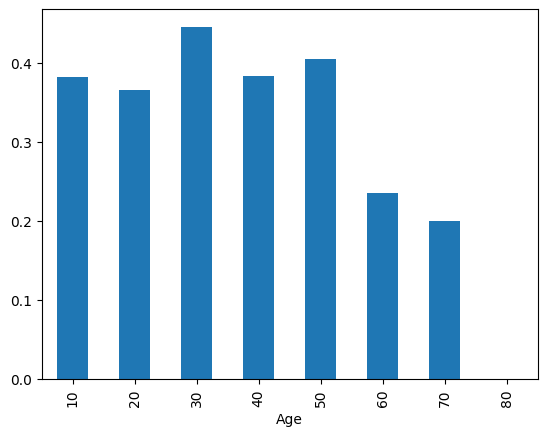

In [590]:
data_df.groupby(['Age'])['Survived'].mean().plot(kind='bar')

60대부터 급감

7.요금


In [591]:
data_df['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [592]:
data_df['Fare'] = pd.cut(data_df['Fare'], bins=[0, 8, 14, 31, 512], labels=['0', '1', '2', '3'])


In [593]:
data_df.groupby(['Fare'])['Survived'].mean()*100

Fare
0    22.566372
1    30.102041
2    43.965517
3    57.534247
Name: Survived, dtype: float64

<Axes: xlabel='Fare'>

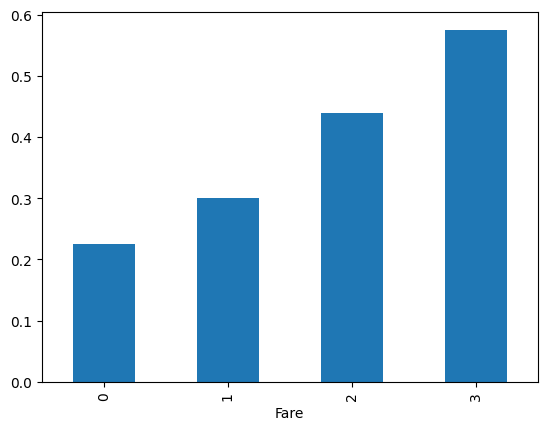

In [594]:
data_df.groupby(['Fare'])['Survived'].mean().plot(kind='bar')

요금을 높게 지불한 사람이 생존률이 높다

전처리

In [595]:
# 가족 유무 별 열추가 # Parch SibSp 열 삭제
X_features['member'] = X_features['Parch'] + X_features['SibSp']
X_features = X_features.drop(['Parch','SibSp'],axis = 1) 

# 테스트
test_df['member'] = test_df['Parch'] + test_df['SibSp']
test_df = test_df.drop(['Parch','SibSp'],axis = 1) 

In [596]:
#값이 1 이상이면 1로 변경
for i in range(len(X_features)): 
    if X_features['member'][i] > 1 : X_features['member'][i] = 1 
    
# 테스트 데이터
for i in range(len(test_df)): 
    if test_df['member'][i] > 1 : test_df['member'][i] = 1

In [597]:
X_features['Sex']=LabelEncoder().fit(['female','male']).transform(X_features['Sex'])
# 테스트 데이터
test_df['Sex']=LabelEncoder().fit(['female','male']).transform(test_df['Sex'])

Age 결측치

In [598]:
X_features_test = [X_features]

for dataset in X_features_test: 
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False) 
    
X_features['Title'].value_counts()

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Ms            1
Mme           1
Don           1
Lady          1
Sir           1
Capt          1
Countess      1
Jonkheer      1
Name: count, dtype: int64

In [599]:
# 테스트
test_df_test = [test_df]

for dataset in test_df_test: 
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False) 
    
test_df['Title'].value_counts()

Title
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: count, dtype: int64

In [600]:
name_mapping = {
    "Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3, "Dr": 4, "Rev": 4, "Col": 4
    , "Major": 4, "Mlle": 4,"Countess": 4, "Ms": 4, "Lady": 4, "Jonkheer": 4
    , "Don": 4, "Dona" : 4, "Mme": 4,"Capt": 4,"Sir": 4 } 

for dataset in X_features_test :
    X_features['Title'] = dataset['Title'].map(name_mapping)

# 테스트 데이터
for dataset in test_df_test :
    test_df['Title'] = dataset['Title'].map(name_mapping)

X_features.head()

,Pclass,Name,Sex,Age,Fare,Embarked,member,Title
0,3,"Braund, Mr. Owen Harris",1,22.0,7.2500,S,1,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,71.2833,C,1,2
2,3,"Heikkinen, Miss. Laina",0,26.0,7.9250,S,0,1
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,53.1000,S,1,2
4,3,"Allen, Mr. William Henry",1,35.0,8.0500,S,0,0


In [543]:
X_features.groupby('Title')['Age'].mean()


Title
0    32.368090
1    21.773973
2    35.898148
3     4.574167
4    42.384615
Name: Age, dtype: float64

title이 nan 인경우 평균값으로 할당

In [602]:
X_features.loc[(X_features['Age'].isnull())&(X_features['Title']==0),'Age'] =32
X_features.loc[(X_features['Age'].isnull())&(X_features['Title']==1),'Age'] =22
X_features.loc[(X_features['Age'].isnull())&(X_features['Title']==2),'Age'] =36
X_features.loc[(X_features['Age'].isnull())&(X_features['Title']==3),'Age'] =5
X_features.loc[(X_features['Age'].isnull())&(X_features['Title']==4),'Age'] =42

In [603]:
# 테스트
test_df.loc[(test_df['Age'].isnull())&(test_df['Title']==0),'Age'] =32
test_df.loc[(test_df['Age'].isnull())&(test_df['Title']==1),'Age'] =22
test_df.loc[(test_df['Age'].isnull())&(test_df['Title']==2),'Age'] =36
test_df.loc[(test_df['Age'].isnull())&(test_df['Title']==3),'Age'] =5
test_df.loc[(test_df['Age'].isnull())&(test_df['Title']==4),'Age'] =42

In [604]:
X_features = X_features.drop(['Name'],axis=1)
# 테스트
test_df = test_df.drop(['Name'],axis=1)

In [605]:
X_features = pd.get_dummies(X_features, columns=['Embarked'], drop_first=True)
# 테스트
test_df = pd.get_dummies(test_df, columns=['Embarked'], drop_first=True)


나이와 요금을 스케일링

In [608]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler

ct = ColumnTransformer(
    transformers=[
        ('age', StandardScaler(), ['Age']),
        ('fare', RobustScaler(), ['Fare'])
    ],
    remainder='passthrough'
)

# 데이터프레임 변환
X_transformed = ct.fit_transform(X_features)
# 테스트
test_transformed = ct.fit_transform(test_df)

# 원래 컬럼명을 가져옴
X_features_col = X_features.columns

# 결과를 DataFrame으로 변환
X_features= pd.DataFrame(X_transformed, columns=X_features_col)
# 테스트
test_df= pd.DataFrame(test_transformed, columns=X_features_col)

In [619]:
# Pclass	Sex	Age	Fare	member	Title	Embarked_Q	Embarked_S
X_features[['Pclass','Sex']] = X_features[['Pclass','Sex']].astype(float)
X_features[['Age','Fare','member','Title']] = X_features[['Age','Fare','member','Title']].astype(int)
X_features[['Embarked_Q','Embarked_S']] = X_features[['Embarked_Q','Embarked_S']].astype(bool)

In [610]:
# 테스트
test_df[['Pclass','Sex']] = test_df[['Pclass','Sex']].astype(float)
test_df[['Age','Fare','member','Title']] = test_df[['Age','Fare','member','Title']].astype(int)
test_df[['Embarked_Q','Embarked_S']] = test_df[['Embarked_Q','Embarked_S']].astype(bool)

In [620]:
X_train, X_test, y_train, y_test = train_test_split(
      X_features
    , y_labels
    , test_size=0.2
    , random_state=0
)

In [621]:
# 조기 종료 => 검증 데이터 분리
X_tr, X_val, y_tr, y_val = train_test_split(
      X_train
    , y_train
    , test_size=0.2
    , random_state=0
)

In [622]:
# 학습, 평가 : AUC score
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [623]:
# 모델 생성
xgb_clf = XGBClassifier(
      n_estimators=1000
    , max_depth=9
    , learning_rate=0.1
    , early_stopping_rounds=100
    , eval_metric='error'
    , random_state=166
)

In [624]:
# lightgbm 모델 생성
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(
      n_estimators=1000
    , num_leaves=64
    , n_jobs=-1
    , early_stopping_rounds=100
    , boost_from_average=False
    )

In [625]:
get_model_train_eval(
      xgb_clf
    , ftr_train=X_tr
    , ftr_test=X_test
    , tgt_train=y_tr
    , tgt_test=y_test
    , eval_set=[(X_val, y_val)]
)

[0]	validation_0-error:0.41958
[1]	validation_0-error:0.41958
[2]	validation_0-error:0.27273
[3]	validation_0-error:0.25874
[4]	validation_0-error:0.23776
[5]	validation_0-error:0.24476
[6]	validation_0-error:0.24476
[7]	validation_0-error:0.26573
[8]	validation_0-error:0.25175
[9]	validation_0-error:0.26573
[10]	validation_0-error:0.25175
[11]	validation_0-error:0.26573
[12]	validation_0-error:0.25175
[13]	validation_0-error:0.25175
[14]	validation_0-error:0.25175
[15]	validation_0-error:0.24476
[16]	validation_0-error:0.23077
[17]	validation_0-error:0.23776
[18]	validation_0-error:0.23077
[19]	validation_0-error:0.23077
[20]	validation_0-error:0.23077
[21]	validation_0-error:0.23077
[22]	validation_0-error:0.23077
[23]	validation_0-error:0.23077
[24]	validation_0-error:0.23077
[25]	validation_0-error:0.23077
[26]	validation_0-error:0.23077
[27]	validation_0-error:0.23077
[28]	validation_0-error:0.23077
[29]	validation_0-error:0.23077
[30]	validation_0-error:0.23077
[31]	validation_0-

In [ ]:
# xgb_clf = XGBClassifier(
#       n_estimators=1000
#     , max_depth=5
#     , learning_rate=0.05
#     , early_stopping_rounds=100
#     , eval_metric='error'
#     , random_state=166
# )

# 오차 행렬
# [[101   9]
#  [ 20  49]]
# 정확도: 0.8380, 정밀도: 0.8448, 재현율: 0.7101,    F1: 0.7717, AUC:0.8856


# 모델 생성
# xgb_clf = XGBClassifier(
#       n_estimators=1000
#     , max_depth=9
#     , learning_rate=0.1
#     , early_stopping_rounds=100
#     , eval_metric='error'
#     , random_state=166
# )

# 오차 행렬
# [[101   9]
#  [ 19  50]]
# 정확도: 0.8436, 정밀도: 0.8475, 재현율: 0.7246,    F1: 0.7812, AUC:0.8930


In [637]:
# # 전체 데이터 학습
# xgb_clf = XGBClassifier(
#       n_estimators=1000
#     , max_depth=9
#     , learning_rate=0.1
#     # , early_stopping_rounds=100
#     # , eval_metric='error'
#     , random_state=166
# )
# # evaluation metric을 auc로, early stopping은 100 으로 설정하고 학습 수행. 
# xgb_clf.fit(X_features, y_labels)

# get_clf_eval(y_test, xgb_clf.predict(X_test), xgb_clf.predict_proba(X_test)[:,1])


오차 행렬
[[108   2]
 [  1  68]]
정확도: 0.9832, 정밀도: 0.9714, 재현율: 0.9855,    F1: 0.9784, AUC:0.9991


In [638]:
test_result = xgb_clf.predict(test_df)

In [639]:
sample = pd.read_csv('../data/titanic/gender_submission.csv')
sample['Survived'] = test_result

In [640]:
sample.to_csv('./titanic_result.csv', index=False)